In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim 

In [2]:
# generate data (sin waves)
T = 20         
L = 1000        
N = 100         

x = np.empty((N,L),dtype=np.float32)
x[:] = np.arange(L) + np.random.randint(-4*T,4*T,N).reshape(N,1)
y = np.sin(x/1.0/T).astype(np.float32)

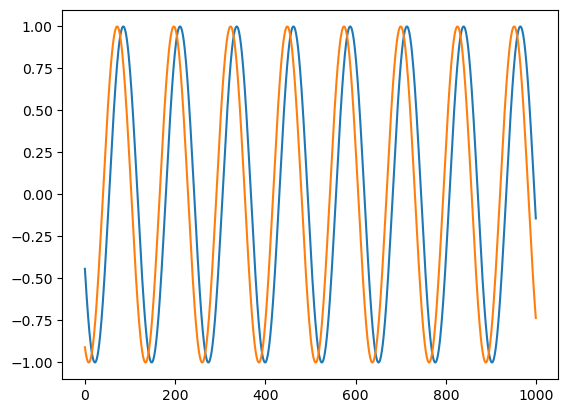

In [3]:
# plot 2 (out of 100)
plt.plot(np.arange(L),y[0])
plt.plot(np.arange(L),y[5])

In [4]:
for input_t in torch.from_numpy(y).split(1,dim=1):
    print(input_t.shape)
    break

torch.Size([100, 1])


In [5]:
# create the LSTM model to predict future
class Sequence(nn.Module):
    def __init__(self,n_hidden=32):
        super().__init__()
        self.n_hidden = n_hidden
        # lstm1, lstm2, linear
        self.lstm1 = nn.LSTMCell(1,self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden,self.n_hidden)
        self.linear = nn.Linear(self.n_hidden,1)
        
    def forward(self,x,future=0):
        outputs = []
        n_samples = x.shape[0]
        # initialize h_t,c_t,h_t2,c_t2
        h_t  = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        c_t  = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        h_t2 = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        c_t2 = torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        
        for input_t in x.split(1,dim=1): # input_t shape = (N,1)
            h_t,c_t   = self.lstm1(input_t,(h_t,c_t))
            h_t2,c_t2 = self.lstm2(h_t,(h_t2,c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        for i in range(future):
            h_t,c_t = self.lstm1(output,(h_t,c_t))
            h_t2,c_t2 = self.lstm2(h_t,(h_t2,c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        outputs = torch.cat(outputs, dim=1)
        return outputs
            

In [6]:
# create test and train data for the model 
train_input = torch.from_numpy(y[5:,:-1]) # (95,999)
train_target = torch.from_numpy(y[5:,1:]) # (95,999)

test_input = torch.from_numpy(y[:5,:-1]) # (5,999)
test_target = torch.from_numpy(y[:5,1:]) # (5,999)

In [7]:
# train the model 
model = Sequence()
loss_fn = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(),lr=0.5)
n_iter = 10

for i in range(n_iter):
    def closure():
        optimizer.zero_grad()
        out = model(train_input)
        loss = loss_fn(out,train_target)
        loss.backward()
        return loss
    optimizer.step(closure)
    
out = model(train_input)
loss = loss_fn(out,train_target)   
print(f'training loss: {loss:.6f}')

training loss: 0.0000


In [8]:
# inference()

with torch.no_grad():
    future = 500
    pred = model(test_input,future=future)
    loss = loss_fn(pred[:,:-future],test_target)
    print(f'test loss:{loss:.6f}')
    y = pred.detach().numpy()

test loss:0.000004


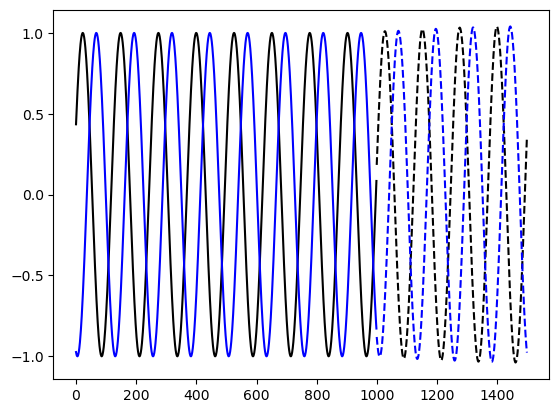

In [9]:
# plot 
def draw(yi,color):
    plt.plot(np.arange(test_input.size(1)),test_input[yi],color)
    plt.plot(np.arange(test_input.size(1),test_input.size(1)+future),y[yi,test_input.size(1):],color + '--')
    
draw(1,'k')
draw(2,'b')